In [1]:
import os

from src.significance_calculator import calculate_approx_global_significance, load_data_from_folder

In [2]:
z_prime_parameters = {
    r"g_{Z'}": 1.0,  # global coupling constant for Z'
    r"\zeta_Q": 0*1.0,  # bottom left
    r"\zeta_L": 0*1.0,  # tau left
    r"\zeta_b": 1.0,  # bottom right
    r"\zeta_\tau": 1.0,  # tau right
}

vlq_parameters = {
    r"$g_U$": 1.0,  # global coupling constant for VLQ
    # r"$\beta_L$": 1.0, # tau left
    r"$\beta_R$": 0*1.0,  # tau right
}

slq_parameters = {
    r"$y_S$": 1.0,  # global coupling constant for SL
}

scale_factors = {
    "Zprime_tau_m_right_bottom_right": (
        z_prime_parameters[r"\zeta_b"] * z_prime_parameters[r"\zeta_\tau"] * z_prime_parameters[r"g_{Z'}"] ** 2
    )
    ** 2,
    "Zprime_tau_m_right_bottom_left": (
        z_prime_parameters[r"\zeta_Q"] * z_prime_parameters[r"\zeta_\tau"] * z_prime_parameters[r"g_{Z'}"] ** 2
    )
    ** 2,
    "Zprime_tau_m_left_bottom_right": (
        z_prime_parameters[r"\zeta_b"] * z_prime_parameters[r"\zeta_L"] * z_prime_parameters[r"g_{Z'}"] ** 2
    )
    ** 2,
    "Zprime_tau_m_left_bottom_left": (
        z_prime_parameters[r"\zeta_Q"] * z_prime_parameters[r"\zeta_L"] * z_prime_parameters[r"g_{Z'}"] ** 2
    )
    ** 2,
    "vLQ_tau_m_L_tau_p_R": (vlq_parameters[r"$g_U$"] ** 2) ** 2,
    "vLQ_tau_m_R_tau_p_L": ((vlq_parameters[r"$\beta_R$"] ** 2) * (vlq_parameters[r"$g_U$"] ** 2)) ** 2,
    "vLQ_tau_m_L_tau_p_L": (vlq_parameters[r"$\beta_R$"] * (vlq_parameters[r"$g_U$"] ** 2)) ** 2,
    "vLQ_tau_m_R_tau_p_R": (vlq_parameters[r"$\beta_R$"] * (vlq_parameters[r"$g_U$"] ** 2)) ** 2,
    "sLQ_tau_m_right": slq_parameters[r"$y_S$"] ** 4,  # global coupling constant for SL
    "sLQ_tau_m_left": slq_parameters[r"$y_S$"] ** 4,  # global coupling constant for SL
}

In [3]:
current_folder = os.getcwd()
data_folder = os.path.join(current_folder, "data")


bkg_folder = os.path.join(data_folder, "bkgs")
backgrounds = load_data_from_folder(bkg_folder)

In [4]:
bin_edges = {
    "visible_met_mass": (
        list(range(60, 300, 12))
        + list(range(300, 420, 12))
        + list(range(420, 480, 15))
        + [480, 510, 550, 610, 670, 750]
        + [900, 2.5e6]  # Overflow bin: 900 to "infinity"
    ),
}

observable = "visible_met_mass"

# check that the observable is in the bin edges
if observable not in bin_edges:
    raise ValueError(f"Observable '{observable}' not found in bin edges.")

In [5]:
def calculate_model_significances(model, masses, data_folder, backgrounds, scale_factors, 
                                observable, bin_edges, query_total, lumi):
    significances = {}
    for mass in masses:
        signals = load_data_from_folder(os.path.join(data_folder, model, str(mass)))
        significances[mass] = calculate_approx_global_significance(
            signals,
            backgrounds,
            model,
            scale_factors,
            observable,
            bin_edges,
            query_total, 
            lumi,
        )
    return significances

# Configuration
masses = list(range(250, 5000, 250))
lumi = 3000 * 1000  # in pb-1, converted to fb-1 for consistency with the scale factors

# Definir las consultas de filtrado para seleccionar eventos específicos
query_a = "event_type == 'hadronic'"  # Solo eventos hadrónicos
query_b = "label == 'ditau_no_bjets'"  # Solo eventos ditau sin jets-b
query_c = "((tau_m_type != 'had') | (tau_m_pt > 70)) & ((tau_p_type != 'had') | (tau_p_pt > 70))"  # Cortes de pT para ambos taus
query_total = f"({query_a}) and ({query_b}) and ({query_c})"  # Combinar todas las condiciones

# Define models to analyze
models = ["Zprime", "vLQ", "sLQ"]

# Calculate significances for all models
all_significances = {}
for model in models:
    print(f"Calculating significances for {model}...")
    all_significances[model] = calculate_model_significances(
        model, masses, data_folder, backgrounds, scale_factors,
        observable, bin_edges[observable], query_total, lumi
    )
    print(f"  Completed {model}")

print("All calculations completed!")

Calculating significances for Zprime...


  Completed Zprime
Calculating significances for vLQ...
  Completed vLQ
Calculating significances for sLQ...
  Completed sLQ
All calculations completed!


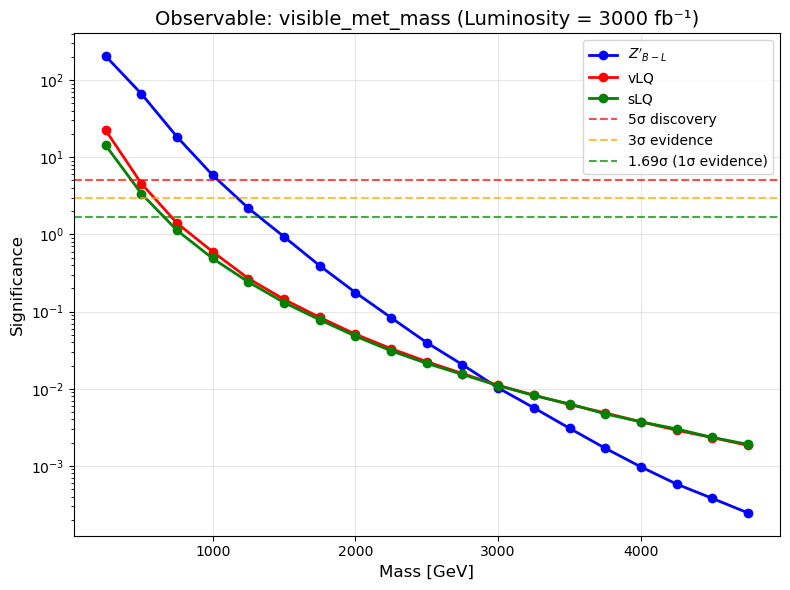

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors and markers for each model
model_styles = {
    "Zprime": {"color": "blue", "marker": "o", "label": r"$Z'_{B-L}$"},
    "vLQ": {"color": "red", "marker": "o", "label": "vLQ"},
    "sLQ": {"color": "green", "marker": "o", "label": "sLQ"}
}

# Create the combined plot
plt.figure(figsize=(8, 6))

# Plot each model using the all_significances dictionary
for model, significances in all_significances.items():
    masses_plot = list(significances.keys())
    significances_plot = list(significances.values())
    
    style = model_styles.get(model, {"color": "black", "marker": "o", "label": model})
    plt.plot(masses_plot, significances_plot, 
             color=style["color"], marker=style["marker"], 
             linestyle="-", linewidth=2, markersize=6, 
             label=style["label"])

plt.xlabel("Mass [GeV]", fontsize=12)
plt.ylabel("Significance", fontsize=12)
plt.title(f"Observable: {observable} (Luminosity = {lumi/1000:.0f} fb⁻¹)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.yscale("log")  # Use log scale for y-axis since significances vary over orders of magnitude

# Add horizontal lines for reference
plt.axhline(y=5, color="r", linestyle="--", alpha=0.7, label="5σ discovery")
plt.axhline(y=3, color="orange", linestyle="--", alpha=0.7, label="3σ evidence")
plt.axhline(y=1.69, color="green", linestyle="--", alpha=0.7, label="1.69σ (1σ evidence)")

plt.legend()
plt.tight_layout()
plt.show()

